# Test

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import datasets

Import datasets using functions from src/data/data.py. Datasets are downloaded from huggingface and stored in /data. Once downloaded, datasets are loaded locally.

Run ```pip install -e .``` if module importing isn't working.

In [6]:
from src.data.data import get_in_domain, get_out_domain
from src.data.data import get_random_subsets

in_domain_train, in_domain_test = get_in_domain()
out_domain = get_out_domain()

print(f"In domain:\n{in_domain_train}")
print(in_domain_train[0])

print(f"Out of domain:\n{out_domain}")
print(out_domain[10])

# get_random_subsets(in_domain)

In domain:
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 261802
})
{'premise': 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him', 'hypothesis': 'You lose the things to the following level if the people recall.', 'label': 0, 'idx': 1}
Out of domain:
Dataset({
    features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
    num_rows: 10000
})
{'premise': 'The president avoided the athlete .', 'hypothesis': 'The athlete avoided the president .', 'label': 1, 'parse_premise': '(ROOT (S (NP (DT The) (NN president)) (VP (VBD avoided) (NP (DT the) (NN athlete))) (. .)))', 'parse_hypothesis': '(ROOT (S (NP (DT The) (NN at

### Import models

Import models using methods from src/models/opt.py. Models are downloaded from huggingface and stored in /models/pretrained. Once downloaded, models are loaded locally.

In [7]:
from src.model.model import get_model

model_opt125, tokenizer_opt125 = get_model('opt-125m')
model_opt350, tokenizer_opt350 = get_model('opt-350m')

### Few-shot finetuning

Perform few-shot fine-tuning using the fine_tune method from /src/finetuners/fewshot.py. This method requires model, tokenizers, and datasets to be passed in as parameters. It returns training and evaluation metrics.

In [12]:
from src.finetuners.fewshot import fine_tune

train_dataset = in_domain_train.select(range(2))
eval_dataset_in = in_domain_test.select(range(2))
eval_dataset_out = out_domain.select(range(2))

fine_tune(model=model_opt125, tokenizer=tokenizer_opt125, train_dataset=train_dataset, eval_dataset_in=eval_dataset_in, eval_dataset_out=eval_dataset_out)

memory reset at beginning of train


100%|██████████| 40/40 [00:09<00:00,  4.39it/s]


peak memory = 2.501376152038574GB
{'train_runtime': 9.1052, 'train_samples_per_second': 8.786, 'train_steps_per_second': 4.393, 'train_loss': 7.4505798863810925e-09, 'epoch': 40.0, 'train_peak_memory_gb': 2.501376152038574}
memory reset at beginning of eval


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]

peak memory = 1.4232711791992188GB


memory reset at beginning of eval


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]

peak memory = 1.4232940673828125GB


{'train_runtime': 9.1052,
 'train_samples_per_second': 8.786,
 'train_steps_per_second': 4.393,
 'train_loss': 7.4505798863810925e-09,
 'epoch': 40.0,
 'train_peak_memory_gb': 2.501376152038574,
 'eval_in_loss': 5.911022663116455,
 'eval_in_accuracy': 0.5,
 'eval_in_runtime': 2.9308,
 'eval_in_samples_per_second': 0.682,
 'eval_in_steps_per_second': 0.341,
 'eval_in_peak_memory_gb': 1.4232711791992188,
 'eval_out_loss': 9.820317268371582,
 'eval_out_accuracy': 0.0,
 'eval_out_runtime': 2.8999,
 'eval_out_samples_per_second': 1.724,
 'eval_out_steps_per_second': 0.345,
 'eval_out_peak_memory_gb': 1.4232940673828125}

### Batch few-shot finetuning

Perform batch few-shot fine-tuning using batch_fine_tune from /src/finetuners/fewshot.py. This method only requires model_name and training and eval datasets. The selected model is loaded from /models/pretrained for each trial to prevent cumulative fine-tuning. sample_sizes corresponds to the number of shots used for each trial. Each trial is trained and evaluated using data randomly selected by get_random_subsets from /src/utils.py. Results are written to a csv in /logs.

In [9]:
import json
from src.finetuners.fewshot import batch_fine_tune
from src.data.data import get_random_subsets

# Generate training and evaluation datasets. These should be used for all fine-tuning methods to ensure consistency. np.random should be seeded before this.
train_datasets, eval_dataset_in, eval_dataset_out = get_random_subsets(train_dataset=in_domain_train, 
                                                                       eval_dataset_in=in_domain_test, 
                                                                       eval_dataset_out=out_domain, 
                                                                       train_sample_sizes=[2, 4, 6, 8, 16],#[2, 16, 32, 64, 128], # [2, 4],
                                                                       num_trials=10,   # 5
                                                                       eval_sample_size=50) # 10

results = batch_fine_tune(model_name='opt-125m', train_datasets=train_datasets, eval_dataset_in=eval_dataset_in, eval_dataset_out=eval_dataset_out)

print(json.dumps(results, indent=4))

2-shot:   0%|          | 0/10 [00:00<?, ?it/s]


KeyboardInterrupt: 

### Plot in domain vs out of domain metrics

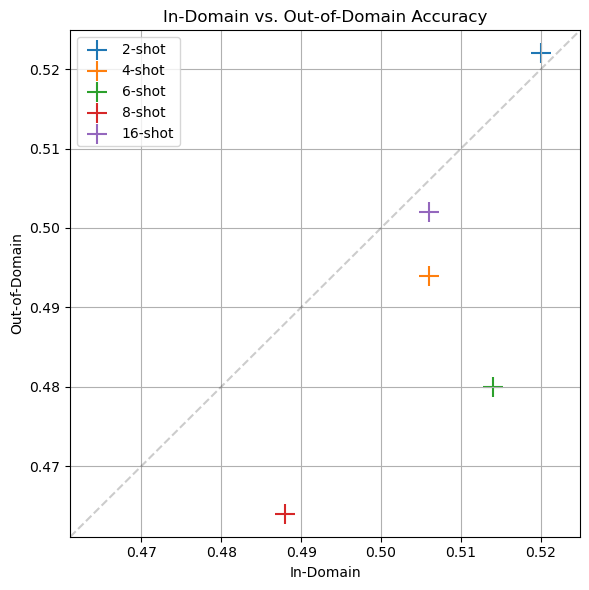

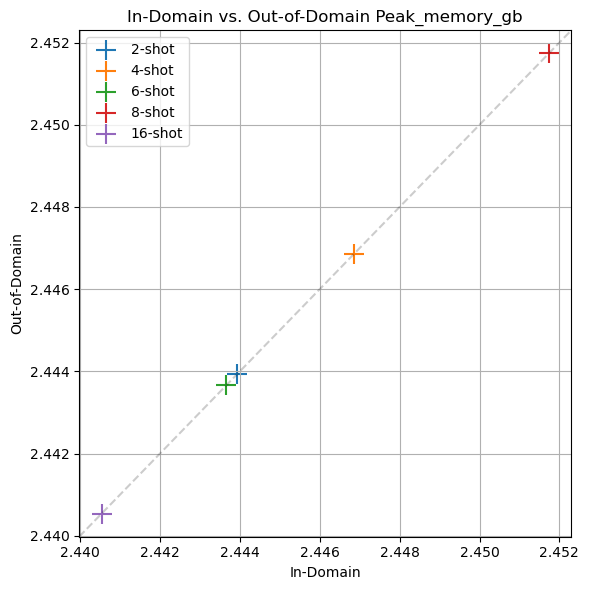

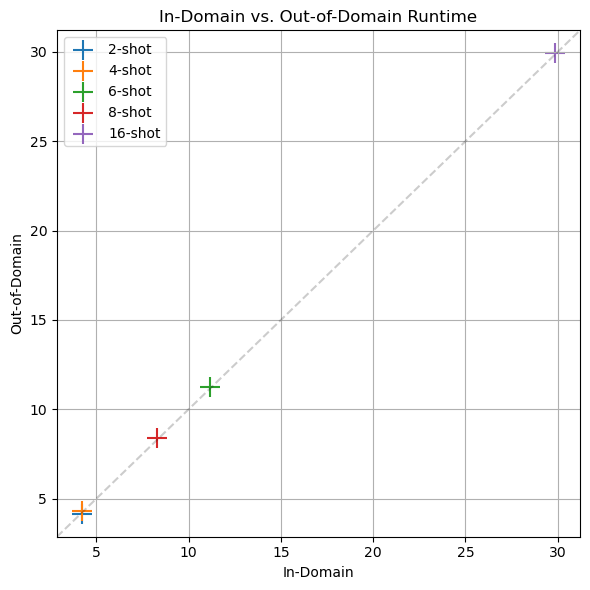

In [ ]:
from src.visualization.plot import plot_in_out_domain

plot_in_out_domain(logfile='opt-125m_fewshot_2_4_6_8_16', metric='accuracy')
plot_in_out_domain(logfile='opt-125m_fewshot_2_4_6_8_16', metric='peak_memory_gb')
plot_in_out_domain(logfile='opt-125m_fewshot_2_4_6_8_16', metric='runtime')